In [1]:
import sys
sys.path.append('../../')
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
from sklearn import metrics, model_selection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision


from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import cv2
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from project.infrastructure.model_trainer import Model
from project.infrastructure.img_dataset import ImageDataset
from project.infrastructure.torchsampler import ImbalancedDatasetSampler
import project.infrastructure.utils as utils
import project.infrastructure.pytorch_util as ptu

In [2]:
current_dir = Path.cwd()
home_dir = Path.home()
print(f"current_dir: {current_dir}")
print(f"home_dir:{home_dir}")

current_dir: /home/yiw084/Documents/GitHub/ECE_228-Team-4/project/test
home_dir:/home/yiw084


In [3]:
# Config data_dir, img_dir
data_dir = Path("../../data/")
leaf_data_dir: str = "cassava-leaf-disease-classification/"
csv_file_name: str = "train.csv"

csv_file_path = data_dir/leaf_data_dir/csv_file_name

In [4]:
img_folder_name: str = "train_images"
img_dir = data_dir/leaf_data_dir/img_folder_name

In [5]:
df = pd.read_csv(csv_file_path)
print(df.shape)
df.head()

(21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
# Noticed that the dataset is unbalanced
# TODO: handle class weight for imbalanced dataset
df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [7]:
# Set seed
SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

if torch.cuda.device_count() > 1:
    torch.cuda.manual_seed_all(SEED)

In [8]:
# set overflow warning to error instead
np.seterr(all='raise')
torch.autograd.set_detect_anomaly(True)

# Enable cuDNN Auto-tuner before launching training loop
# Improve performance (For convolutional networks only!)
torch.backends.cudnn.benchmark = True

In [9]:
# Split dataset into train and valid
df_train, df_valid = model_selection.train_test_split(
    df,
    test_size=0.1,
    train_size=0.9,
    random_state=SEED,
    stratify=df.label.values
)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train.shape, df_valid.shape

((19257, 2), (2140, 2))

In [10]:
df_train.head()

,image_id,label
0,1724663202.jpg,1
1,1443500189.jpg,0
2,3794321240.jpg,3
3,358823158.jpg,3
4,681211585.jpg,4


In [11]:
df_valid.head()

,image_id,label
0,3512385051.jpg,4
1,592844774.jpg,3
2,3547680343.jpg,4
3,41606397.jpg,1
4,2417340627.jpg,2


In [12]:
# Get image path for both training and validation
# Remember to convert path object to str!!
train_img_paths = [str(img_dir/img_id) for img_id in df_train["image_id"].values]
valid_img_paths = [str(img_dir/img_id) for img_id in df_valid["image_id"].values]

# Get image label for both training and validation
train_targets = df_train.label.values
valid_targets = df_valid.label.values

# Verify img paths
train_img_paths[:3], valid_img_paths[:3]

(['../../data/cassava-leaf-disease-classification/train_images/1724663202.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/1443500189.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3794321240.jpg'],
 ['../../data/cassava-leaf-disease-classification/train_images/3512385051.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/592844774.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3547680343.jpg'])

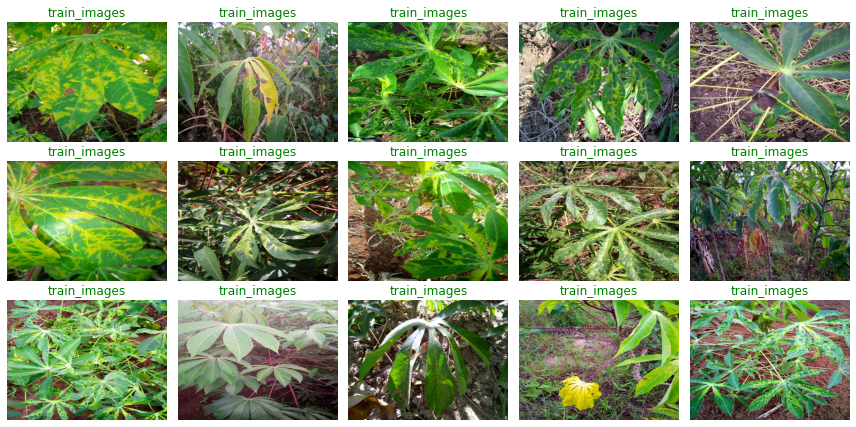

In [13]:
# show images
utils.display_image_grid(images_filepaths=train_img_paths[0:15])

In [14]:
# Training augmentation
train_img_aug = A.Compose(
    [
        A.RandomResizedCrop(width=256, height=256),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(
            shift_limit=(0.2, 0.2), scale_limit=(1.1, 1.1), rotate_limit=(45, 45), p=0.5
        ),
        A.GridDistortion(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

# Validation augmentation
valid_img_aug = A.Compose(
    [
        A.RandomCrop(width=256, height=256, p=1.0),
        A.Resize(width=256, height=256),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [15]:
# clear gpu cache to release memory
torch.cuda.empty_cache()

# Create training and validation dataset
train_dataset = ImageDataset(
    image_paths=train_img_paths,
    targets=train_targets,
    augmentations=train_img_aug
)

valid_dataset = ImageDataset(
    image_paths=valid_img_paths,
    targets=valid_targets,
    augmentations=valid_img_aug
)

print(train_dataset[100], '\n')
print(type(train_dataset[100]))



{'image': tensor([[[  1.,  41.,   0.,  ...,  45.,  48.,  51.],
         [  1.,  30.,  11.,  ...,  48.,  49.,  54.],
         [ 37.,   8.,  10.,  ...,  53.,  52.,  59.],
         ...,
         [  0.,   5.,  16.,  ..., 158., 145., 152.],
         [  8.,  20.,  38.,  ..., 152., 137., 138.],
         [ 42.,  46., 155.,  ..., 152., 139., 108.]],

        [[  0.,  33.,   0.,  ...,  68.,  70.,  73.],
         [  0.,  20.,   0.,  ...,  70.,  71.,  75.],
         [ 19.,   0.,   0.,  ...,  73.,  73.,  77.],
         ...,
         [  0.,   0.,   0.,  ..., 176., 169., 159.],
         [  0.,   0.,   0.,  ..., 169., 164., 146.],
         [  0.,   0.,  93.,  ..., 177., 168., 150.]],

        [[  0.,  29.,   0.,  ...,  52.,  54.,  59.],
         [  0.,  17.,   0.,  ...,  54.,  55.,  63.],
         [ 19.,   0.,   0.,  ...,  59.,  58.,  64.],
         ...,
         [  0.,   0.,   0.,  ..., 131., 127., 132.],
         [  0.,   0.,   0.,  ..., 129., 118., 123.],
         [  0.,   0.,  95.,  ..., 129., 118

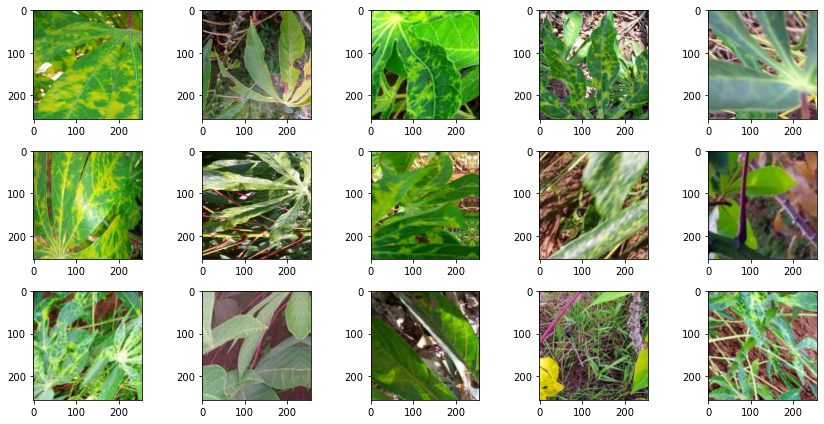

In [16]:
# Visualize training images after augmentation
train_images_array_lst = [train_dataset[i]['image'] for i in range(15)]
utils.display_image_grid(images_array_lst=train_images_array_lst)

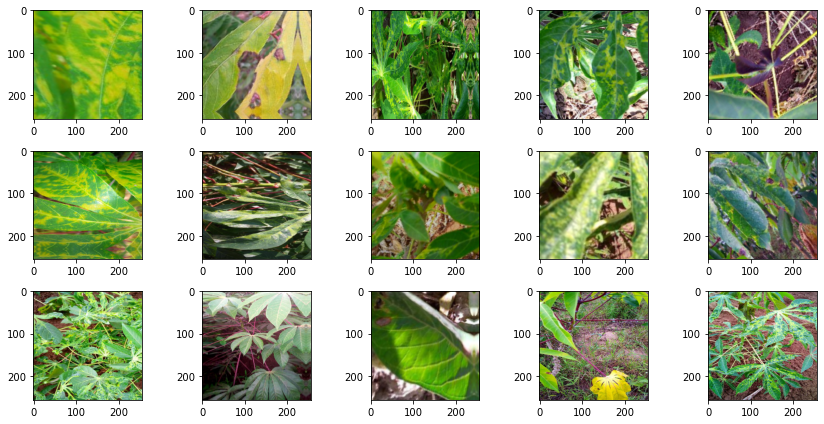

In [17]:
# Visualize validation images after augmentation
valid_images_array_lst = [train_dataset[j]['image'] for j in range(15)]
utils.display_image_grid(images_array_lst=valid_images_array_lst)


In [18]:
class LeafDiseaseClassifier(Model):
    def __init__(self, params: dict,):
        super().__init__()
        self.params = params
        self.resnet18 = torchvision.models.resnet18(pretrained=params["pretrained"])
        self.resnet18.fc = nn.Linear(in_features=512, out_features=params["output_size"], bias=True)

    def config_optimizer(self, *args, **kwargs):
        opt = optim.Adam(self.parameters(), lr=self.params["learning_rate"])
        return opt

    # def config_scheduler(self, *args, **kwargs):
    #     assert self.optimizer is not None, "Please set up optimizer first"
    #     sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=30, verbose=False)
    #     return sch

    @staticmethod
    def loss_fn(outputs, targets, criterion=None):
        """ calculate loss """
        if targets is None or criterion is None:
            print("Targets is None or Criterion is None")
            return None
        return criterion(outputs, targets)

    def forward(self, x, targets):
        out: torch.FloatTensor = self.resnet18(x)
        criterion = nn.CrossEntropyLoss()
        loss: torch.FloatTensor = self.loss_fn(out, targets, criterion)
        return out, loss

    def monitor_metrics(self, outputs, targets=None) -> dict:
        outputs: np.ndarray = ptu.to_numpy(torch.argmax(outputs, dim=1))
        targets: np.ndarray = ptu.to_numpy(targets)
        accuracy = metrics.accuracy_score(targets, outputs)
        val_metrics = {
            "acc": accuracy,
        }
        return val_metrics

In [19]:
# TODO: change param
print(df.label.unique().shape[0])
# training param
params = {
    "output_size":5,
    "max_epochs": 3,
    "train_batch_size": 32,
    "valid_batch_size": 32*2,
    'fp16': True,
    'seed': 42,
    'no_gpu': False,
    'which_gpu': 0,
    'num_workers': -1,
    'learning_rate': 5e-4,
    'pretrained': True,

}
assert params["output_size"] == df.label.unique().shape[0]

In [20]:
# Create ResNet50
resnet18_model = LeafDiseaseClassifier(params)

In [21]:
# Check if NN build successfully
img = train_dataset[0]["image"]
target = train_dataset[0]["target"]
img, target

(tensor([[[ 29.,  48.,  55.,  ...,  32.,  54.,  54.],
          [ 32.,  45.,  56.,  ...,  55.,  42.,  42.],
          [ 33.,  47.,  62.,  ...,  73.,  50.,  50.],
          ...,
          [ 87.,  90.,  98.,  ...,  40.,  36.,  36.],
          [ 86.,  87.,  92.,  ...,  43.,  42.,  42.],
          [ 86.,  87.,  92.,  ...,  43.,  42.,  42.]],
 
         [[ 98., 113., 118.,  ...,  34.,  56.,  56.],
          [ 98., 110., 118.,  ...,  60.,  48.,  48.],
          [100., 111., 122.,  ...,  71.,  50.,  50.],
          ...,
          [143., 144., 151.,  ...,  29.,  22.,  22.],
          [146., 145., 150.,  ...,  33.,  30.,  30.],
          [146., 145., 150.,  ...,  33.,  30.,  30.]],
 
         [[  0.,   4.,   1.,  ...,   7.,  23.,  23.],
          [  0.,   0.,   0.,  ...,  39.,  22.,  22.],
          [  0.,   1.,   1.,  ...,  57.,  30.,  30.],
          ...,
          [  4.,   0.,   4.,  ...,  21.,  18.,  18.],
          [  6.,   0.,   1.,  ...,  22.,  21.,  21.],
          [  6.,   0.,   1.,  .

In [22]:
# Build success
resnet18_model(img.unsqueeze(0), target.unsqueeze(0))

(tensor([[ 0.0306,  0.5307, -0.2656,  0.8153,  0.2816]],
        grad_fn=<AddmmBackward>),
 tensor(1.4270, grad_fn=<NllLossBackward>))

In [23]:
# Init GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)



cuda:0


In [24]:
# init Trainer
resnet18_model.init_trainer(params)

# metrics are store in history: dict
history = resnet18_model.fit(
    train_dataset=train_dataset, train_batch_size=params["train_batch_size"],
    valid_dataset=valid_dataset, valid_batch_size=params["valid_batch_size"],
    max_epochs=params["max_epochs"], device=device,
    train_sampler=None,  #ImbalancedDatasetSampler(train_dataset),
    valid_sampler=None,  #ImbalancedDatasetSampler(valid_dataset),
    num_workers=params["num_workers"], use_fp16=params['fp16'],
                    
)

Using GPU id 0
############ cuda:0: AMP=True ############


LDD:   0%|          | 0/3 [00:00<?, ?it/s]


Train One Epoch...


(AMP) Epoch: 0:  33%|███▎      | 1/3 [03:12<06:25, 192.71s/it, acc=0.681, train_loss=0.908, val_loss=0.831]


Train One Epoch...


(AMP) Epoch: 1:  67%|██████▋   | 2/3 [06:25<03:12, 192.89s/it, acc=0.552, train_loss=0.795, val_loss=1.22] 


Train One Epoch...


(AMP) Epoch: 2: 100%|██████████| 3/3 [09:36<00:00, 192.16s/it, acc=0.764, train_loss=0.755, val_loss=0.666]


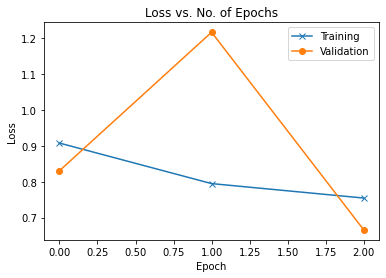

In [25]:
train_losses = history['train_loss']
val_losses = history['val_loss']
plt.plot(train_losses, '-x')
plt.plot(val_losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of Epochs')
plt.show()



(3,)


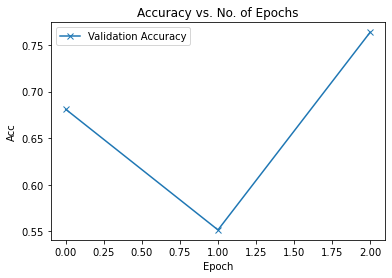

In [26]:
val_acc = np.array(history['acc'])
avg_acc = np.vstack(val_acc).mean(axis=1)
print(avg_acc.shape)
plt.plot(avg_acc, '-x')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Validation Accuracy'])
plt.title('Accuracy vs. No. of Epochs')
plt.show()

In [27]:
# TODO: add confusion_mtx
